In [1]:
# Note: gym changed from version 0.7.3 to 0.8.0
# MountainCar episode length is capped at 200 in later versions.
# This means your agent can't learn as much in the earlier episodes
# since they are no longer as long.   
#
# Adapt Q-Learning script to use TD(lambda) method instead

import gymnasium as gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [2]:
env = gym.make('MountainCar-v0')
env.observation_space.sample()

array([-0.2767909 , -0.06890015], dtype=float32)

In [3]:
env.action_space, env.action_space.sample()

(Discrete(3), 0)

In [4]:
# SGDRegressor defaults:
# loss='squared_loss', penalty='l2', alpha=0.0001,
# l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True,
# verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling',
# eta0=0.01, power_t=0.25, warm_start=False, average=False

# Inspired by https://github.com/dennybritz/reinforcement-learning
class FeatureTransformer:
  def __init__(self, env, n_components=500):
    observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # z-transform
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    example_features = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = example_features.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observations):
    # print "observations:", observations
    scaled = self.scaler.transform(observations)
    # assert(len(scaled.shape) == 2)
    return self.featurizer.transform(scaled)

In [5]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [6]:
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  # both X and Y will be of shape (num_tiles, num_tiles)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  # Z will also be of shape (num_tiles, num_tiles)

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()

In [7]:
class BaseModel:
  def __init__(self, D):
    self.w = np.random.randn(D) / np.sqrt(D)

  def partial_fit(self, input_, target, eligibility, lr=1e-2):
    # previously self.w += self.lr*(Y - X.dot(self.w)).dot(X)
    self.w += lr*(target - input_.dot(self.w))*eligibility

  def predict(self, X):
    X = np.array(X)
    return X.dot(self.w)

In [8]:
# Holds one BaseModel for each action
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer

    D = feature_transformer.dimensions
    self.eligibilities = np.zeros((env.action_space.n, D))
    for i in range(env.action_space.n):
      model = BaseModel(D)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform([s])
    assert(len(X.shape) == 2)
    result = np.stack([m.predict(X) for m in self.models]).T
    assert(len(result.shape) == 2)
    return result

  def update(self, s, a, G, gamma, lambda_):
    X = self.feature_transformer.transform([s])
    assert(len(X.shape) == 2)
    self.eligibilities *= gamma*lambda_
    # gradient is X[0] wrt to weights
    self.eligibilities[a] += X[0]
    self.models[a].partial_fit(X[0], G, self.eligibilities[a])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

In [12]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, env, eps, gamma, lambda_):
  observation = env.reset()[0]
  done = False
  totalreward = 0
  iters = 0
  # while not done and iters < 200:
  while not done and iters < 10000:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, trunc, info = env.step(action)

    # update the model
    next = model.predict(observation)
    assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next[0])
    model.update(prev_observation, action, G, gamma, lambda_)

    totalreward += reward
    iters += 1

  return totalreward

In [13]:
env = gym.make('MountainCar-v0')
ft = FeatureTransformer(env)
model = Model(env, ft)
gamma = 0.9999
lambda_ = 0.7

In [14]:
N = 300
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    # eps = 1.0/(0.1*n+1)
    eps = 0.1*(0.97**n)
    # eps = 0.5/np.sqrt(n+1)
    totalreward = play_one(model, env, eps, gamma, lambda_)
    totalrewards[n] = totalreward
    print("episode:", n, "total reward:", totalreward)
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", -totalrewards.sum())

episode: 0 total reward: -2528.0
episode: 1 total reward: -983.0
episode: 2 total reward: -666.0
episode: 3 total reward: -621.0
episode: 4 total reward: -603.0
episode: 5 total reward: -458.0
episode: 6 total reward: -675.0
episode: 7 total reward: -253.0
episode: 8 total reward: -278.0
episode: 9 total reward: -212.0
episode: 10 total reward: -329.0
episode: 11 total reward: -299.0
episode: 12 total reward: -236.0
episode: 13 total reward: -168.0
episode: 14 total reward: -326.0
episode: 15 total reward: -295.0
episode: 16 total reward: -278.0
episode: 17 total reward: -194.0
episode: 18 total reward: -242.0
episode: 19 total reward: -151.0
episode: 20 total reward: -154.0
episode: 21 total reward: -151.0
episode: 22 total reward: -123.0
episode: 23 total reward: -152.0
episode: 24 total reward: -144.0
episode: 25 total reward: -115.0
episode: 26 total reward: -192.0
episode: 27 total reward: -131.0
episode: 28 total reward: -148.0
episode: 29 total reward: -150.0
episode: 30 total r

episode: 247 total reward: -152.0
episode: 248 total reward: -124.0
episode: 249 total reward: -87.0
episode: 250 total reward: -126.0
episode: 251 total reward: -140.0
episode: 252 total reward: -131.0
episode: 253 total reward: -137.0
episode: 254 total reward: -119.0
episode: 255 total reward: -110.0
episode: 256 total reward: -93.0
episode: 257 total reward: -105.0
episode: 258 total reward: -95.0
episode: 259 total reward: -149.0
episode: 260 total reward: -128.0
episode: 261 total reward: -124.0
episode: 262 total reward: -122.0
episode: 263 total reward: -147.0
episode: 264 total reward: -126.0
episode: 265 total reward: -124.0
episode: 266 total reward: -91.0
episode: 267 total reward: -123.0
episode: 268 total reward: -137.0
episode: 269 total reward: -155.0
episode: 270 total reward: -128.0
episode: 271 total reward: -123.0
episode: 272 total reward: -133.0
episode: 273 total reward: -148.0
episode: 274 total reward: -137.0
episode: 275 total reward: -133.0
episode: 276 total

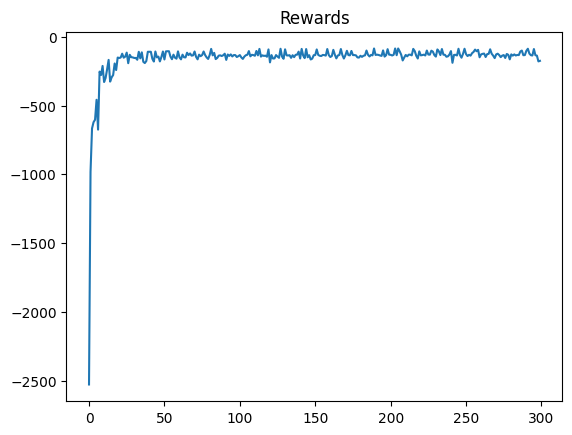

In [15]:
plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

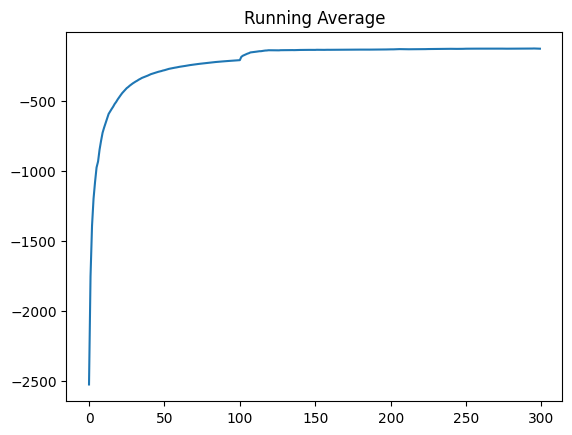

In [16]:
plot_running_avg(totalrewards)

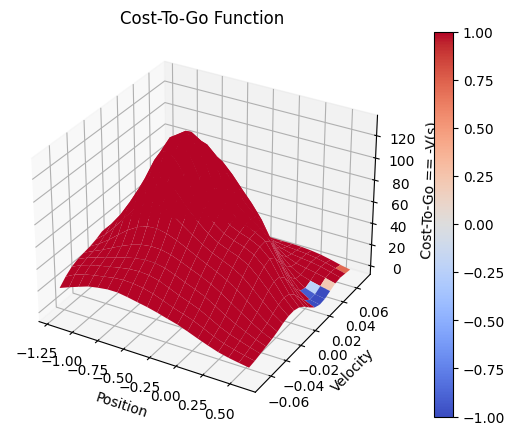

In [17]:
# plot the optimal state-value function
plot_cost_to_go(env, model)
